In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import Dataset, DataLoader
import shutil
from PIL import Image
import torchvision.transforms.functional as TF
from skimage.util import random_noise
import torch.nn.init as init
import math
import torch.nn.functional as F


# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

Random Seed:  999
cuda:0


In [ ]:
#directory paths: please change these
root_dir = '' #directory containing full dataset of celeba images
train_pth = '' #directory for training images
val_pth = '' #directory for validation images
test_pth = '' #directory for test images

train_f = 0.8 #split for training set
val_f = 0.1 # split for val/test sets

#make train and test directories if they do not exist
if not os.path.isdir(train_pth):
    os.mkdir(train_pth)

if not os.path.isdir(val_pth):
    os.mkdir(val_pth)

if not os.path.isdir(test_pth):
    os.mkdir(test_pth)

#find list of files 
img_names = os.listdir(root_dir)
no_files = len(img_names)

t = int(train_f*no_files)
v = int(val_f*no_files)

#copy train images
for i in np.arange(0,t):
    og_pth = os.path.join(root_dir, img_names[i])
    sv_pth = os.path.join(train_pth, img_names[i])

    shutil.copy(og_pth,sv_pth)
    if i%10==1:
        print(i)

#copy validation images
for i in np.arange(t,t+v):
    og_pth = os.path.join(root_dir, img_names[i])
    sv_pth = os.path.join(val_pth, img_names[i])

    shutil.copy(og_pth,sv_pth)
    if i%10==1:
        print(i)

#copy test images
for i in np.arange(t+v,no_files):
    og_pth = os.path.join(root_dir, img_names[i])
    sv_pth = os.path.join(test_pth, img_names[i])

    shutil.copy(og_pth,sv_pth)
    if i%100==1:
        print(i)


In [ ]:
def show_image(image, title=None, style=None):
    plt.figure(figsize=(8, 8))
    if title:
        plt.title(title)
    if type(image) == torch.Tensor:
        image = image.numpy().transpose(1, 2, 0)
    plt.imshow(image, cmap=style)
    plt.show()
    
def show_image_grayscale(image, title=None, style=None):
    plt.figure(figsize=(8, 8))
    if title:
        plt.title(title)
    if type(image) == torch.Tensor:
        image = image.numpy().squeeze()
    plt.imshow(image, cmap=style)
    plt.show()

def get_psnr(img_1, img_2):
    img_1 = img_1.astype(np.float) # convert to float first
    img_2 = img_2.astype(np.float)
    mse = np.mean(np.square(img_1 - img_2))
    if mse == 0: # same image
        return float('inf')
    return 10 * np.log10(255.0**2 / mse)

def normalize_tensor(cur_tensor):
  b, c, h, w = cur_tensor.shape
  min_v, _ = torch.min(cur_tensor.view(b, c, -1), dim=2)
  max_v, _ = torch.max(cur_tensor.view(b, c, -1), dim=2)
  min_v = min_v.view(b, c, 1, 1)
  max_v = max_v.view(b, c, 1, 1)
  return (cur_tensor - min_v) / (max_v - min_v)

def get_psnr_torch(tensor_1, tensor_2):
    
    # Normalize the tensors
    tensor_1 = normalize_tensor(tensor_1)
    tensor_2 = normalize_tensor(tensor_2)
    
    # Calculate PSNR
    mse = F.mse_loss(tensor_1, tensor_2)
    psnr = 10 * torch.log10(1 / mse)
    return psnr

In [ ]:
class GeneralImageDataset(Dataset):
    def __init__(self, gt_dir, output_size=(128, 128), sigma=15):
        """
        Args:
            gt_dir (string): Directory with all original images.
        """
        
        self.gt_dir = gt_dir
        self.output_size = output_size
        self.sigma = sigma
        self.gt_image_names = []
        
        for gt_image_name in os.listdir(self.gt_dir):
          _, image_extension = os.path.splitext(gt_image_name)
          if image_extension == '.jpg':
            self.gt_image_names.append(gt_image_name)
        
    def __len__(self):
        return len(self.gt_image_names)

    def __getitem__(self, idx):
        
        cur_gt_image_name = self.gt_image_names[idx] 
        
        # Load images
        gt_image = Image.open(os.path.join(self.gt_dir, cur_gt_image_name))

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            gt_image, 
            output_size=self.output_size
            )
        gt_image = TF.crop(gt_image, i, j, h, w)

        #To tensor
        gt_image = TF.to_tensor(gt_image)

        
        #Add Noise

        #noisy_image = gt_image + (1 / 255) * self.sigma * torch.randn(gt_image.shape)
        
        sig = self.sigma
        if torch.max(gt_image[0,:,:,]) <= 1:
            sig = sig/255
        noisy_image = gt_image + sig * torch.randn(gt_image.shape)
        
            
        processed_images_dict = {
            'noisy': noisy_image,
            'gt': gt_image
        }              
        return processed_images_dict

In [ ]:
class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=3, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        #return out
        return y+out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                #print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

In [ ]:
# Train the model
def train_net(net, options, criterion, train_set, test_set):
    
    net.train()
    
    print('Start training...')
    print('Epoch\tTrain Loss\tTrain Error\tTest Loss\tTest Error\t')

    train_loader = DataLoader(
        train_set, 
        batch_size=options['batch_size'], 
        num_workers=options['num_workers'],
        shuffle=options['shuffle'],
        pin_memory=True
        )
    
    test_loader = DataLoader(
        test_set, 
        batch_size=options['batch_size'], 
        num_workers=options['num_workers'],
        shuffle=False,
        pin_memory=True
        )
    
    optimizer = torch.optim.Adam(
        net.parameters(), 
        lr=options['base_lr'], 
        weight_decay=options['weight_decay']
        )
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=options['scheduler_factor'], 
        patience=options['scheduler_patience'], 
        verbose=True, 
        threshold=1e-3
    )
    
    # Best metric
    best_metric = 0
    grph = []

    for i in range(options['epochs']):
        
        epoch_loss = []
        epoch_metric = []
         
        iter_ct = 0
        for data in train_loader:

            x = data['noisy'].to(device)
            y = data['gt'].to(device)

            # Clear the existing gradients.
            optimizer.zero_grad()

            # Forward pass
            y_hat = net(x)
            loss = criterion(y_hat, y)

            loss.backward()
            
            # Clip the gradients
            #torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            optimizer.step()
            
            epoch_loss.append(loss.data.item())
            
            y_hat_detached = y_hat.detach()
            y_detached = y.detach() 
            epoch_metric.append(get_psnr_torch(y_hat_detached, y_detached))
            #epoch_metric.append(get_psnr_torch(y_hat, y))
            grph = np.append(grph,np.array([loss]))
            iter_ct = iter_ct+1
            #print('\t%4.6f' % ( 
            #      loss)) 
            if iter_ct%100 == 100-1:
                print('--Iter %d\t%4.6f' % (
                iter_ct, 
                loss
                ))
        # Train loss & error
        avg_epoch_loss = sum(epoch_loss) / len(epoch_loss)
        avg_epoch_metric = sum(epoch_metric) / len(epoch_metric)
        
        # Display the train images
        if options['train_display'] \
        and (i % options['display_epoch'] == options['display_epoch'] - 1):
            
            # Train images
            inp = x.detach().cpu()[0]
            img = y_hat.detach().cpu()[0]
            ground_truth = y.detach().cpu()[0]
            
            print('Train Result for Epoch %d:' % i)  
            show_image(inp)
            show_image(img)
            show_image(ground_truth)
        
        # Display the test images
        if options['test_display'] \
        and (i % options['display_epoch'] == options['display_epoch'] - 1):
          display_cur_image = True
        else:
          display_cur_image = False

        avg_test_loss, avg_metric = test_net(
            net,
            test_loader, 
            criterion, 
            show_res=display_cur_image
            )
        # Print Results
        print('%d\t%4.6f\t%4.6f\t%4.6f\t%4.6f\t' % (
            i, 
            avg_epoch_loss, 
            avg_epoch_metric, 
            avg_test_loss, 
            avg_metric
            )
        )
        
        # Scheduler
        scheduler.step(avg_epoch_loss) 
        
        if options['save_flag'] and avg_metric > best_metric and i >= options['save_epoch']: #
            
            # Update the error
            best_metric = max(avg_metric, best_metric)
            
            # Save the model
            torch.save(
                net.state_dict(),
                os.path.join(options['model_path'], options['model_name'])
            )
            
            # Print
            print('Saving...')
        #return grph





# Test the model
def test_net(net, test_loader, criterion, show_res=False):
    
    net.eval() # Set the net to eval mode
    
    display_flag = show_res
    test_loss = []
    test_metrics = []
    
    with torch.no_grad():
        for data in test_loader:
            
            x = data['noisy'].to(device)
            y = data['gt'].to(device)

            # Forward pass
            y_hat = net(x)
            loss = criterion(y_hat, y)
            test_loss.append(loss.data.item())
            test_metrics.append(get_psnr_torch(y_hat, y))
        
            # Show the image
            if display_flag == True:
                inp = x.detach().cpu()[0]
                img = y_hat.detach().cpu()[0]
                ground_truth = y.detach().cpu()[0]

                print('Test Result')
                show_image(inp)
                show_image(img)
                show_image(ground_truth)

                display_flag = False # Show one test image only
    
    net.train()# Set the net to train mode

    # Print Results
    avg_loss = sum(test_loss) / len(test_loss)
    avg_metric = sum(test_metrics) / len(test_metrics)
    return avg_loss, avg_metric

In [ ]:
########## Hyperparameter ##########
base_lr = 0.005 #0.001 #0.005 #0.01
batch_size = 16
epochs = 20 #20 #15 #50
weight_decay = 0  
scheduler_factor = 0.8
scheduler_patience = 40
display_epoch = 1  
display_scale = 1
train_display = True
test_display = True
num_workers = 4
shuffle = True
save_flag = True
save_epoch = 1
model_path = '' #path in which network parameters are saved
model_name = 'denoise_dncnn.pth'
########## Hyperparameter ##########

# Make dir
if not os.path.isdir(model_path):
    print('Create new dir.')
    os.mkdir(model_path)

training_size = (128, 128)
sigma_train = 10 #15 #12 #9 #6 #3 #10
sigma_test = 10 #15 #12 #9 #6 #3 #10
net_D = 8;
net_C = 16;
train_Path = ''
val_Path = ''

train_set = GeneralImageDataset(
    train_Path,
    training_size,
    sigma=sigma_train
    )
validation_set = GeneralImageDataset(
    val_Path,
    training_size,
    sigma=sigma_test
    )

net = DnCNN(depth=net_D, n_channels=net_C).to(device)
 
options = {
    'base_lr': base_lr,
    'batch_size': batch_size,
    'epochs': epochs,
    'weight_decay': weight_decay,
    'scheduler_factor': scheduler_factor,
    'scheduler_patience': scheduler_patience,
    'display_epoch': display_epoch,
    'display_scale': display_scale,
    'train_display': train_display,
    'test_display': test_display,
    'num_workers': num_workers,
    'shuffle': shuffle,
    'save_flag': save_flag, 
    'save_epoch': save_epoch,
    'model_path': model_path,
    'model_name': model_name
}


criterion = nn.L1Loss()
train_net(
    net, 
    options, 
    criterion, 
    train_set, 
    validation_set,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Result


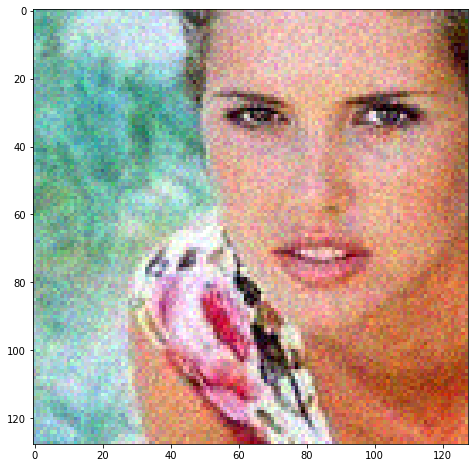

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


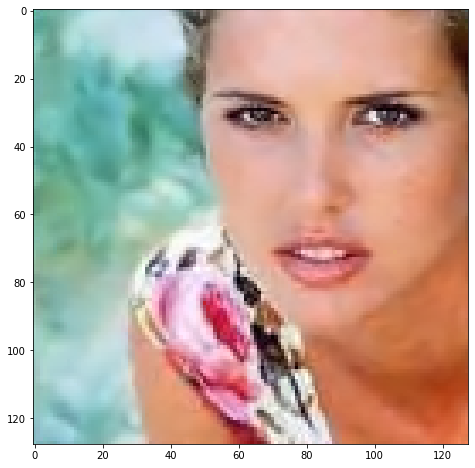

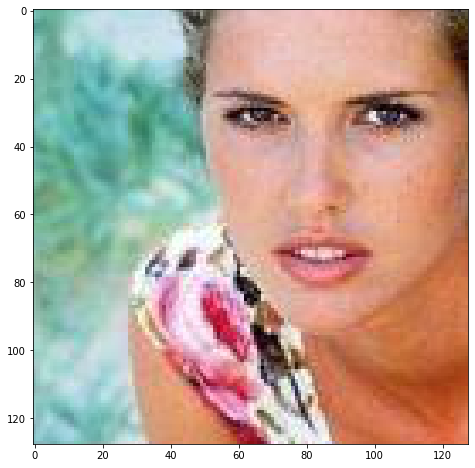

0.014717539719389222 tensor(28.4977, device='cuda:0')


In [ ]:
test_size = (128, 128)
sigma_test = 15 #12 #9 #6 #3 #10
test_set = GeneralImageDataset(
    '', #test set path
    test_size,
    sigma=sigma_test
    )
test_loader = DataLoader(
        test_set, 
        batch_size=16, 
        num_workers=4,
        shuffle=True,
        pin_memory=True
        )
net_D = 8
net_C = 16
weight_Path = '' # path to load saved weights
net = DnCNN(depth=net_D, n_channels=net_C).to(device)
net.load_state_dict(torch.load(weight_Path)) 

criterion = nn.L1Loss()
avg_loss, avg_metric =  test_net(net, test_loader, criterion, show_res=True)
print(avg_loss, avg_metric)